In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised import SupervisedDataLoader
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)

24-Feb-19 18:47:08 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
24-Feb-19 18:47:09 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [4]:
load_app_config()
DATA_DIRECTORY='HRAnalytics'
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "is_promoted"
input_path = get_datafolder_path()

24-Feb-19 18:47:17 - INFO - Adding D:\DataSource to system path
24-Feb-19 18:47:17 - INFO - Adding D:\MachineLearning to system path


In [5]:
filepath  = pathlib.Path(input_path).joinpath(DATA_DIRECTORY)
train_filepath = filepath.joinpath(TRAIN_FILE)
test_filepath = filepath.joinpath(TEST_FILE)

In [6]:
supervisedloader = SupervisedDataLoader(train_file=train_filepath,test_file=test_filepath,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
train_y = train_dataset[RESPONSE]

24-Feb-19 18:47:17 - INFO - Loading train_file :D:\DataSource\HRAnalytics\train.csv
24-Feb-19 18:47:18 - INFO - Loading test_file :D:\DataSource\HRAnalytics\test.csv


In [7]:
def get_nullcounts(dataset):
    nullcount_frame = pd.DataFrame({'Feature':dataset.columns.values,
                                    'Missing_Values': dataset.shape[0] - dataset.count().values, })
    nullcount_frame = nullcount_frame[nullcount_frame['Missing_Values']>0].reset_index(drop=True)
    nullcount_frame['Missing_Values%'] = (nullcount_frame['Missing_Values']/dataset.shape[0])*100
    return nullcount_frame

In [8]:
train_dataset.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,"54,808.0000","54,808.0000","54,808.0000","50,684.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000","54,808.0000"
mean,"39,195.8306",1.2530,34.8039,3.3293,5.8655,0.3520,0.0232,63.3868,0.0852
std,"22,586.5814",0.6093,7.6602,1.2600,4.2651,0.4776,0.1505,13.3716,0.2791
min,1.0000,1.0000,20.0000,1.0000,1.0000,0.0000,0.0000,39.0000,0.0000
25%,"19,669.7500",1.0000,29.0000,3.0000,3.0000,0.0000,0.0000,51.0000,0.0000
50%,"39,225.5000",1.0000,33.0000,3.0000,5.0000,0.0000,0.0000,60.0000,0.0000
75%,"58,730.5000",1.0000,39.0000,4.0000,7.0000,1.0000,0.0000,76.0000,0.0000
max,"78,298.0000",10.0000,60.0000,5.0000,37.0000,1.0000,1.0000,99.0000,1.0000


In [9]:
display(train_dataset.head())
display(test_dataset.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0000,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0000,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0000,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0000,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0000,2,0,0,73,0


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,nan,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0000,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0000,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0000,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0000,7,0,0,61


### EDA 
##### Highly imbalanced dataset

In [10]:
print("% of target variable")
train_dataset['is_promoted'].value_counts()/train_dataset.shape[0]

% of target variable


0   0.9148
1   0.0852
Name: is_promoted, dtype: float64

### Imputing missing values

In [11]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%
0,education,2409,4.3953
1,previous_year_rating,4124,7.5244


,Feature,Missing_Values,Missing_Values%
0,education,1034,4.4019
1,previous_year_rating,1812,7.7139


In [12]:
train_rating_by_region_department =train_dataset .groupby(['region','department']) ['previous_year_rating'].median()

In [13]:
train_rating_by_region_department.head()

region    department
region_1  Analytics    4.0000
          Finance      3.0000
          HR           4.5000
          Legal        3.0000
          Operations   4.0000
Name: previous_year_rating, dtype: float64

In [14]:
test_rating_by_region_department = test_dataset.groupby(['region','department'])['previous_year_rating'].median()

In [15]:
def impute_rating(row):
    return train_rating_by_region_department[row['region'],row['department']]

In [16]:
train_dataset['previous_year_rating'].fillna(train_dataset[train_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [17]:
test_dataset['previous_year_rating'].fillna(test_dataset[test_dataset['previous_year_rating'].isnull()].apply(impute_rating, axis=1), inplace=True)

In [18]:
train_education_mode = train_dataset.groupby(['department']).agg({'education':lambda x: x.value_counts(dropna=False).index[0]}).reset_index()

In [19]:
train_education_mode

,department,education
0,Analytics,Bachelor's
1,Finance,Bachelor's
2,HR,Bachelor's
3,Legal,Bachelor's
4,Operations,Bachelor's
5,Procurement,Bachelor's
6,R&D,Bachelor's
7,Sales & Marketing,Bachelor's
8,Technology,Bachelor's


In [20]:
train_dataset['education'].fillna("Bachelor's",inplace=True)
test_dataset['education'].fillna("Bachelor's",inplace=True)

In [21]:
display(get_nullcounts(train_dataset))
display(get_nullcounts(test_dataset))

,Feature,Missing_Values,Missing_Values%


,Feature,Missing_Values,Missing_Values%


In [22]:
full_dataset = pd.concat(objs=[train_dataset,test_dataset],axis=0,sort =True).reset_index(drop=True) 

In [23]:
full_dataset['department'].value_counts() 
full_dataset['education'].value_counts() 

Bachelor's          55690
Master's & above    21429
Below Secondary      1179
Name: education, dtype: int64

In [24]:
department_encoding = {'R&D':1,'Legal':1,'HR':2,'Finance':2,
                       'Analytics':3,'Technology':4,'Procurement':4,
                       'Operations':5,'Sales & Marketing':5}

education_encoding = {"Bachelor's":3,"Master's & above":2,'Below Secondary':1}

gender_encoding = {'f':0,'m':1}
recruitment_channel_encoding = {'other':3,'sourcing':2, 'referred':1}


In [25]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78298 entries, 0 to 78297
Data columns (total 14 columns):
KPIs_met >80%           78298 non-null int64
age                     78298 non-null int64
avg_training_score      78298 non-null int64
awards_won?             78298 non-null int64
department              78298 non-null object
education               78298 non-null object
employee_id             78298 non-null int64
gender                  78298 non-null object
is_promoted             54808 non-null float64
length_of_service       78298 non-null int64
no_of_trainings         78298 non-null int64
previous_year_rating    78298 non-null float64
recruitment_channel     78298 non-null object
region                  78298 non-null object
dtypes: float64(2), int64(7), object(5)
memory usage: 8.4+ MB


In [26]:
full_dataset['department'] =full_dataset['department'].map(department_encoding)
full_dataset['education'] =full_dataset['education'].map(education_encoding)
full_dataset['gender'] =full_dataset['gender'].map(gender_encoding)
full_dataset['recruitment_channel'] =full_dataset['recruitment_channel'].map(recruitment_channel_encoding)
full_dataset['previous_year_rating'] =full_dataset['previous_year_rating'].astype(int)

In [27]:
full_dataset = pd.get_dummies(full_dataset, columns = ["region",],prefix="d_")
train_dataset['previous_year_rating'] =train_dataset['previous_year_rating'].astype(int)
full_dataset.rename(columns={'KPIs_met >80%': 'KPIs_met_GT_80', 'awards_won?': 'awards_won'}, inplace=True)

In [28]:
full_dataset.head()

,KPIs_met_GT_80,age,avg_training_score,awards_won,department,education,employee_id,gender,is_promoted,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,d__region_1,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9
0,1,35,49,0,5,2,65438,0,0.0000,8,1,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,30,60,0,5,3,65141,1,0.0000,4,1,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,34,50,0,5,3,7513,1,0.0000,7,1,3,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,39,50,0,5,3,2542,1,0.0000,10,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,45,73,0,4,3,48945,1,0.0000,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
train_dataset =full_dataset[full_dataset['is_promoted'].notnull()]
test_dataset  = full_dataset[full_dataset['is_promoted'].isnull()]
test_dataset_emp =test_dataset['employee_id']
train_y=full_dataset[full_dataset['is_promoted'].notnull()]['is_promoted']

full_dataset.drop(['is_promoted','employee_id'],axis =1,inplace=True)
train_dataset.drop(['is_promoted','employee_id'],axis =1,inplace=True)
test_dataset.drop(['is_promoted','employee_id'],axis =1,inplace=True)


In [30]:
kfold = StratifiedKFold(n_splits=10)
from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
test_size = 0.25
seed = 2

X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_dataset, train_y, test_size=test_size,random_state=seed)

In [31]:
X_trainmodel.head()


,KPIs_met_GT_80,age,avg_training_score,awards_won,department,education,gender,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,d__region_1,d__region_10,d__region_11,d__region_12,d__region_13,d__region_14,d__region_15,d__region_16,d__region_17,d__region_18,d__region_19,d__region_2,d__region_20,d__region_21,d__region_22,d__region_23,d__region_24,d__region_25,d__region_26,d__region_27,d__region_28,d__region_29,d__region_3,d__region_30,d__region_31,d__region_32,d__region_33,d__region_34,d__region_4,d__region_5,d__region_6,d__region_7,d__region_8,d__region_9
26984,1,43,68,0,4,2,1,5,1,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
668,0,39,68,0,4,2,0,5,2,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
44692,1,39,85,0,3,3,1,7,1,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5678,1,31,62,0,5,3,1,4,1,4,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43038,0,44,61,0,5,3,0,17,1,3,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction

def select_features_by_XTree(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(selected_features.shape[0],1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [33]:
features_XTree = select_features_by_XTree(X_trainmodel,y_trainmodel)
features = features_XTree[features_XTree['model_result'] > 0.0002]


In [34]:
selected_features = list(features['name'].values)
",".join(selected_features)

'avg_training_score,age,length_of_service,previous_year_rating,department,KPIs_met_GT_80,recruitment_channel,awards_won,no_of_trainings,gender,education,d__region_2,d__region_13,d__region_22,d__region_7,d__region_15,d__region_28,d__region_26,d__region_31,d__region_27,d__region_16,d__region_4,d__region_11,d__region_23,d__region_20,d__region_30,d__region_14,d__region_25,d__region_19,d__region_10,d__region_1,d__region_17,d__region_29,d__region_32,d__region_8,d__region_12,d__region_6,d__region_3,d__region_5,d__region_21,d__region_24,d__region_33,d__region_9,d__region_34'

In [35]:
from yellowbrick.features import Rank1D, Rank2D 
from yellowbrick.features import RadViz

In [36]:
#features =X_trainmodel.columns.values

24-Feb-19 18:47:44 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000
24-Feb-19 18:47:44 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


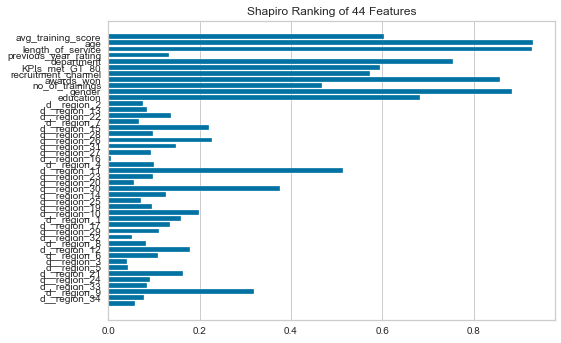

In [37]:
visualizer = Rank1D(features=selected_features, algorithm='shapiro')
visualizer.fit(X_trainmodel, y_trainmodel)                # Fit the data to the visualizer
visualizer.transform(X_trainmodel)             # Transform the data
visualizer.poof()     

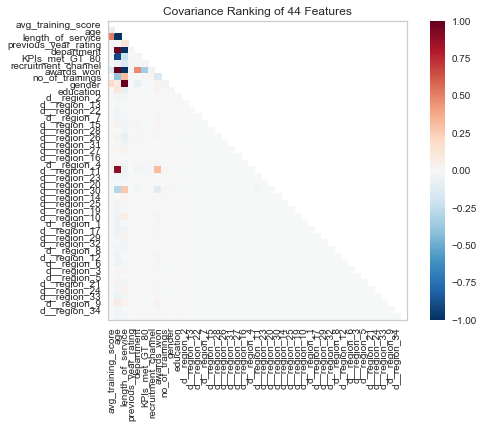

In [38]:
visualizer = Rank2D(features=selected_features, algorithm='covariance')
visualizer.fit(X_trainmodel, y_trainmodel)                # Fit the data to the visualizer
visualizer.transform(X_trainmodel)             # Transform the data
visualizer.poof()  

In [39]:
from sklearn.linear_model  import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel , y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 91.972


In [40]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [41]:
SEED = 222
np.random.seed(SEED)

In [42]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=6)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=50, max_features=3, random_state=SEED)

    models = {#'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

In [43]:
def train_predict(model_list,xtrain, ytrain,xval,yval):
    """Fit models in list on training set and return preds"""
    P = np.zeros((yval.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xval)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


In [44]:
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [45]:
models = get_models()
P = train_predict(models,X_trainmodel, y_trainmodel,X_val,y_val)


Fitting models.
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.



In [46]:
from sklearn.metrics import roc_auc_score
score_models(P, y_val)

Scoring models.
knn                       : 0.688
naive bayes               : 0.710
mlp-nn                    : 0.855
random forest             : 0.832
gbm                       : 0.871
logistic                  : 0.812
Done.



In [47]:
from mlens.visualization import corrmat

[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (4096): C:\Users\krish\AppData\Local\Temp\.mlens_tmp_cache_7wyvaxy_
        Total size: 4096
[MLENS] Removing... done.


24-Feb-19 18:50:39 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


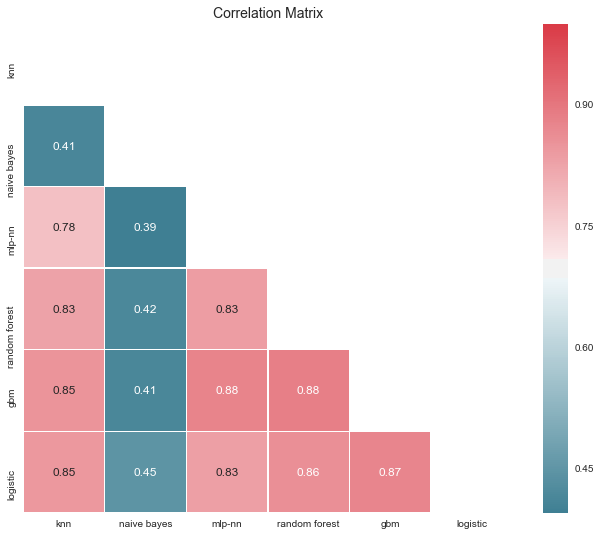

In [48]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_val.values).corr(), inflate=False)
plt.show()

24-Feb-19 18:50:40 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


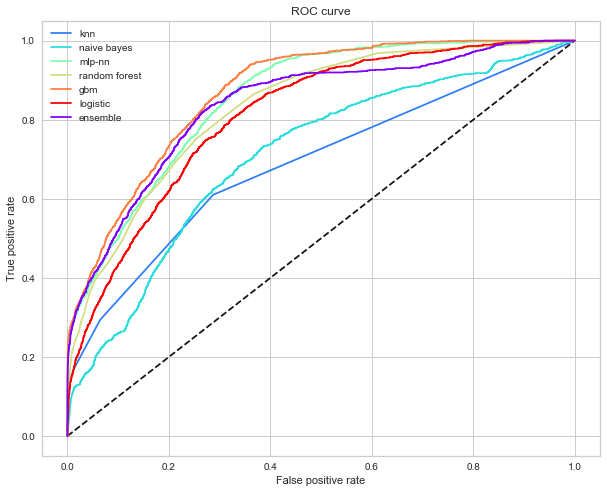

In [49]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(y_val, P.values, P.mean(axis=1), list(P.columns), "ensemble")

### Step 1: define a library of base learners

In [50]:
base_models =  get_models()


### Step 2: define a meta learner

In [51]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

In [52]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(X_trainmodel, y_trainmodel, test_size=test_size,random_state=SEED)

In [53]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [54]:
train_base_learners(base_models, xtrain_base, ytrain_base)

Fitting models.
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [55]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [56]:
P_base = predict_base_learners(base_models, xpred_base)

Generating base learner predictions.
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [57]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=222,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [58]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [59]:
P_pred, p = ensemble_predict(base_models, meta_learner, X_val)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(y_val, p))

Generating base learner predictions.
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.874


In [60]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_models.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_trainmodel, y_trainmodel)




Fitting 2 layers
Processing layer-1             done | 00:10:58
Processing layer-2             done | 00:00:31
Fit complete                        | 00:11:31

Predicting 2 layers
Processing layer-1             done | 00:00:23
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:24

Predicting 2 layers
Processing layer-1             done | 00:00:16
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:17


In [92]:
# Predict the test set
p_sl = sl.predict_proba(test_dataset)

#p_slp = sl.predict(test_dataset)


Predicting 2 layers
Processing layer-1             done | 00:00:30
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:32


In [93]:
prob = p_sl[::,1]

In [94]:
prob= np.where(prob > 0.6, 1, 0)
print(prob)

[0 0 0 ... 0 0 1]


In [95]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':prob}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="HR_Analytics_SuperLearner"+timestamp+"_out.csv"

In [96]:
submission.to_csv(filename,index=False)

In [80]:
P_pred, predictions = ensemble_predict(base_models, meta_learner, test_dataset)

Generating base learner predictions.
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [84]:
predictions = np.where(predictions > 0.5, 1, 0)
print(predictions)

[0 0 0 ... 0 0 1]


In [88]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':predictions}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="HR_Analytics_Ensemble"+timestamp+"_out.csv"
submission.to_csv(filename,index=False)

In [98]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [100]:
from xgboost.sklearn import XGBClassifier

xgbclf= XGBClassifier(n_estimators=100, silent=False)
xgbclf.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

#best_model ,result = test_classifier(xgbclf,X_trainmodel,y_trainmodel,kfold)
print(xgbclf)


NameError: name 'best_model' is not defined

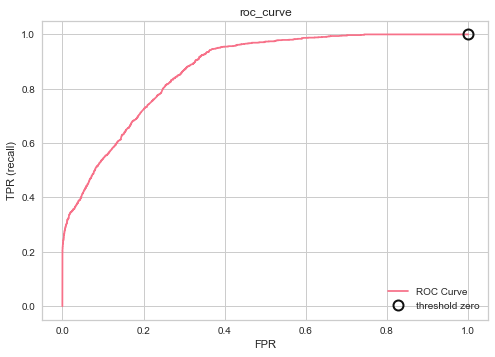

In [101]:
plot_roc(X_val,y_val,xgbclf)

In [102]:
import xgboost as xgb

In [116]:
from sklearn.metrics import f1_score
def calc_f1_score(predictions, y_test):
    labels = y_test.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in predictions]
    return 'f1',f1_score(labels,y_bin)

In [165]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.8,
          "max_depth": 3,
          "subsample": 0.8,
          'colsample_bylevel': 0.6,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          'scale_pos_weight':1
          }

num_boost_round =200

In [166]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_f1_score, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.076582	eval-merror:0.078018	train-f1:0.200609	eval-f1:0.195636
Multiple eval metrics have been passed: 'eval-f1' will be used for early stopping.

Will train until eval-f1 hasn't improved in 50 rounds.
[1]	train-merror:0.074393	eval-merror:0.076339	train-f1:0.227778	eval-f1:0.218236
[2]	train-merror:0.07432	eval-merror:0.076266	train-f1:0.229119	eval-f1:0.219567
[3]	train-merror:0.074247	eval-merror:0.075536	train-f1:0.233166	eval-f1:0.230483
[4]	train-merror:0.072739	eval-merror:0.073931	train-f1:0.255849	eval-f1:0.258961
[5]	train-merror:0.068019	eval-merror:0.069041	train-f1:0.338381	eval-f1:0.342142
[6]	train-merror:0.068117	eval-merror:0.069187	train-f1:0.337435	eval-f1:0.339833
[7]	train-merror:0.068141	eval-merror:0.069041	train-f1:0.337668	eval-f1:0.343056
[8]	train-merror:0.068627	eval-merror:0.069406	train-f1:0.330724	eval-f1:0.340042
[9]	train-merror:0.067241	eval-merror:0.068384	train-f1:0.356611	eval-f1:0.361282
[10]	train-merror:0.

[98]	train-merror:0.062327	eval-merror:0.066122	train-f1:0.439878	eval-f1:0.424396
[99]	train-merror:0.06201	eval-merror:0.066268	train-f1:0.444541	eval-f1:0.424588
[100]	train-merror:0.062156	eval-merror:0.066049	train-f1:0.442991	eval-f1:0.425397
[101]	train-merror:0.062229	eval-merror:0.066195	train-f1:0.442215	eval-f1:0.424857
[102]	train-merror:0.062351	eval-merror:0.066122	train-f1:0.441977	eval-f1:0.425856
[103]	train-merror:0.062302	eval-merror:0.066122	train-f1:0.442169	eval-f1:0.425856
[104]	train-merror:0.062424	eval-merror:0.066487	train-f1:0.439983	eval-f1:0.421587
[105]	train-merror:0.062351	eval-merror:0.066341	train-f1:0.440026	eval-f1:0.42065
[106]	train-merror:0.062375	eval-merror:0.066195	train-f1:0.43944	eval-f1:0.421925
[107]	train-merror:0.062375	eval-merror:0.066487	train-f1:0.438212	eval-f1:0.420115
[108]	train-merror:0.062254	eval-merror:0.066706	train-f1:0.439921	eval-f1:0.420051
[109]	train-merror:0.062035	eval-merror:0.066487	train-f1:0.442257	eval-f1:0.4215

In [167]:
test_y  =gbm.predict(xgb.DMatrix(test_dataset))

In [168]:
submission =pd.DataFrame({'employee_id':test_dataset_emp.values ,'is_promoted':test_y}) 
#submission['Loan_Status'].replace(0, 'N',inplace=True)
#submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="HR_Analytics_XgBoost"+timestamp+"_out.csv"
submission.to_csv(filename,index=False)